In [8]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from wasserstein import Spectrum, NMRSpectrum

from typing import List

import numpy as np

import ot

components_names = ["Pinene", "Benzyl benzoate"]

protons_list = [16, 12]

filename = "preprocessed_mix.csv"
mix = np.loadtxt(filename, delimiter=",")

how_many_components = len(components_names)
names = ["comp" + str(i) for i in range(how_many_components)]

files_with_components = ["preprocessed_comp0.csv", "preprocessed_comp1.csv"]
spectra = []
for i in range(how_many_components):
    filename = files_with_components[i]
    spectra.append(np.loadtxt(filename, delimiter=","))
    # If you are using file exported from Mnova, comment line above and uncomment line below.
    # spectra.append(np.loadtxt(filename, delimiter='\t', usecols=[0,1]))

spectra2: List[NMRSpectrum] = []
names = []
for i in range(len(spectra)):
    spectra2.append(
        NMRSpectrum(
            confs=list(zip(spectra[i][:, 0], spectra[i][:, 1])), protons=protons_list[i]
        )
    )
    names.append("comp" + str(i))

spectra = spectra2
del spectra2
mix = NMRSpectrum(confs=list(zip(mix[:, 0], mix[:, 1])))
mix.trim_negative_intensities()
mix.normalize()
for sp in spectra:
    sp.trim_negative_intensities()
    sp.normalize()

In [113]:
def signif_features(spectrum, n_features):
    spectrum_confs = sorted(spectrum.confs, key=lambda x: x[1], reverse=True)[:n_features]
    spectrum_signif = NMRSpectrum(confs=spectrum_confs, protons=spectrum.protons)
    spectrum_signif.normalize()
    return spectrum_signif

def true_cost_matrix(spectrum1, spectrum2, threshhold=5.0):
    vals1 = [val for val, _ in spectrum1.confs]
    vals2 = [val for val, _ in spectrum2.confs]
    
    # cost = np.full((len(vals1), len(vals2)), 0)
    cost = np.zeros((len(vals1), len(vals2)))
    
    for i, v1 in enumerate(vals1):
        for j, v2 in enumerate(vals2):
            # if abs(v1 - v2) <= threshhold:
            cost[i, j] = abs(v1 - v2)

    return cost

TEST_N = 100

aprox_p = np.array([0.6, 0.4])
aprox_mix = Spectrum.ScalarProduct([signif_features(spectra[0], TEST_N), signif_features(spectra[1], TEST_N)], aprox_p)
aprox_mix.normalize()
mix_test = signif_features(mix, 2*TEST_N)

p1 = np.array([p for _, p in mix_test.confs])
v1 = np.array([v for v, _ in mix_test.confs])
p2 = np.array([p for _, p in aprox_mix.confs])
v2 = np.array([v for v, _ in aprox_mix.confs])
M_test = true_cost_matrix(mix_test, aprox_mix)

aprox_mix_full = Spectrum.ScalarProduct([spectra[0], spectra[1]], aprox_p)
aprox_mix_full.normalize()

p1_full = np.array([p for _, p in mix.confs])
v1_full = np.array([v for v, _ in mix.confs])
p2_full = np.array([p for _, p in aprox_mix_full.confs])
v2_full = np.array([v for v, _ in aprox_mix_full.confs])
# M_test_full = true_cost_matrix(mix, aprox_mix_full)

In [24]:
# E_p1(v1) - E_p2(v2)
def ws_direct(spectrum1, spectrum2):
    vals1 = np.array([val for val, _ in spectrum1.confs])
    a = np.array([p for _, p in spectrum1.confs])

    vals2 = np.array([val for val, _ in spectrum2.confs])
    b = np.array([p for _, p in spectrum2.confs])

    return abs(np.dot(a, vals1) - np.dot(b, vals2))

In [110]:
print(mix_test.WSDistance(aprox_mix))
print(mix.WSDistance(aprox_mix_full))

0.538909809657031
0.7285894991538487


In [107]:
from scipy.stats import wasserstein_distance

print(wasserstein_distance(v1, v2, p1, p2))
print(wasserstein_distance(p1_full, p2_full, v1_full, v2_full))

0.5389098096570313
8.10150371486125e-06


In [108]:
print(ws_direct(mix_test, aprox_mix))
print(ws_direct(mix, aprox_mix_full))

0.4506515671773599
0.7285317991918303


In [39]:
print(ot.emd2(p1, p2, M_test))
print(ot.emd2_1d(x_a=v1, x_b=v2, a=p1, b=p2, metric="euclidean"))
print(ot.emd2_1d(x_a=v1_full, x_b=v2_full, a=p1_full, b=p2_full, metric="euclidean"))

# G = ot.emd_1d(x_a=v1_full, x_b=v2_full, a=p1_full, b=p2_full, metric="euclidean")

0.2564464980257745
0.33411815747757795


In [114]:
#torch
import torch

def true_cost_matrix(spectrum1, spectrum2, threshold=5.0):
    vals1 = torch.tensor([val for val, _ in spectrum1.confs], dtype=torch.float64)
    vals2 = torch.tensor([val for val, _ in spectrum2.confs], dtype=torch.float64)
    
    # Broadcasting to compute absolute differences
    cost = torch.abs(vals1[:, None] - vals2[None, :])
    # cost = torch.sqrt((vals1[:, None] - vals2[None, :]) ** 2 + 1e-6)
    
    return cost

# Extract probability and value tensors
p1_t_full = torch.tensor([p for _, p in mix.confs], dtype=torch.float64)
v1_t_full = torch.tensor([v for v, _ in mix.confs], dtype=torch.float64)
p2_t_full = torch.tensor([p for _, p in aprox_mix_full.confs], dtype=torch.float64)
v2_t_full = torch.tensor([v for v, _ in aprox_mix_full.confs], dtype=torch.float64)

# Compute the cost matrix
p1_t = torch.tensor([p for _, p in mix_test.confs], dtype=torch.float64)
v1_t = torch.tensor([v for v, _ in mix_test.confs], dtype=torch.float64)
p2_t = torch.tensor([p for _, p in aprox_mix.confs], dtype=torch.float64)
v2_t = torch.tensor([v for v, _ in aprox_mix.confs], dtype=torch.float64)
M_t = true_cost_matrix(mix_test, aprox_mix)


# G = ot.emd_1d(x_a=v1_t_full, x_b=v2_t_full, a=p1_t_full, b=p2_t_full, metric="euclidean", dense=False)

In [96]:
G0, log = ot.unbalanced.lbfgsb_unbalanced(p1_t, p2_t, M_t, reg=1, reg_m=torch.tensor([0.005, 0.005], dtype=torch.float64), reg_div='kl', regm_div='tv', log=True, verbose=True, numItermax=4500)
print(log["res"])
print(log["cost"], log["total_cost"])
print(ot.emd2_1d(x_a=v1, x_b=v2, a=p1, b=p2, metric="euclidean"))

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.6775537838492122
        x: [ 1.220e-05  1.374e-05 ...  8.312e-06  8.054e-06]
      nit: 904
      jac: [ 1.877e-07  1.630e-07 ... -8.247e-07 -6.543e-07]
     nfev: 1160
     njev: 1160
 hess_inv: <40000x40000 LbfgsInvHessProduct with dtype=float64>
tensor(0.1143, dtype=torch.float64) tensor(0.6776, dtype=torch.float64)
0.41524832833756675


In [94]:
G0, log = ot.unbalanced.lbfgsb_unbalanced(p1_t, p2_t, M_t, reg=0.1, reg_m=torch.tensor([0.01, 0.01], dtype=torch.float64), reg_div='kl', regm_div='tv', log=True, verbose=True, numItermax=500)
print(log["res"])
print(log["cost"], log["total_cost"])

  message: STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 0.10120720844743217
        x: [ 1.309e-05  1.499e-05 ...  9.723e-06  9.318e-06]
      nit: 500
      jac: [ 1.028e-02  1.182e-02 ...  3.234e-03  2.034e-03]
     nfev: 695
     njev: 695
 hess_inv: <40000x40000 LbfgsInvHessProduct with dtype=float64>
tensor(0.0045, dtype=torch.float64) tensor(0.1012, dtype=torch.float64)


Mirror Descent (2 weights): 100%|██████████| 30/30 [17:06<00:00, 34.21s/it]


Final weights:
  comp1 = 0.3189
  comp2 = 0.6811


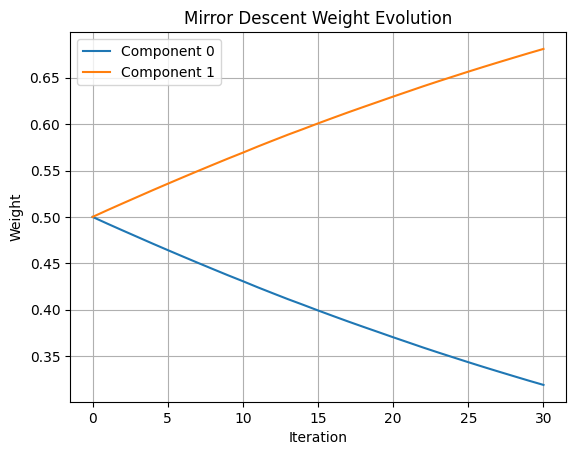

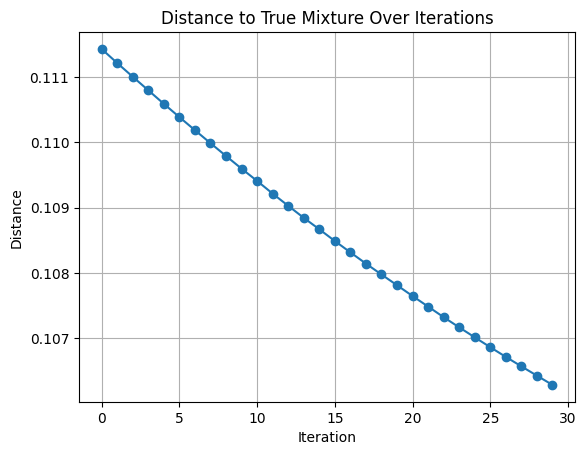

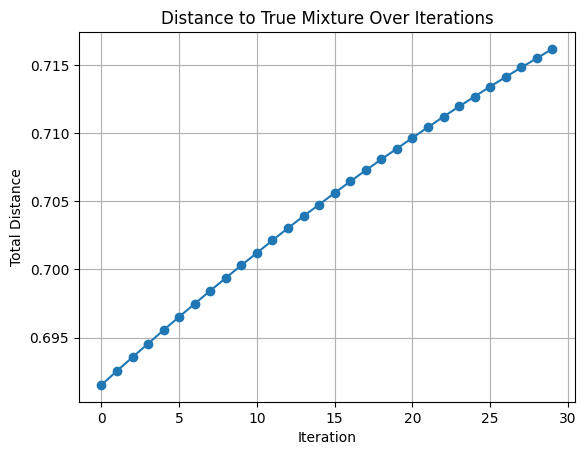

In [117]:
import matplotlib.pyplot as plt
from tqdm import trange

def calculate_gradient_ot(mix, comp0, comp1, p, G0=None, epsilon=1e-5):
    delta = epsilon

    p_plus = np.array([p[0] + delta, p[1] - delta])
    p_minus = np.array([p[0] - delta, p[1] + delta])

    p_plus = np.clip(p_plus, 1e-6, 1)
    p_plus /= p_plus.sum()

    p_minus = np.clip(p_minus, 1e-6, 1)
    p_minus /= p_minus.sum()

    sp_plus = Spectrum.ScalarProduct([comp0, comp1], p_plus)
    sp_minus = Spectrum.ScalarProduct([comp0, comp1], p_minus)

    sp_plus.normalize()
    sp_minus.normalize()

    # grad = (mix.WSDistance(sp_plus) - mix.WSDistance(sp_minus)) / (2 * epsilon)

    a = torch.tensor([p for _, p in mix.confs], dtype=torch.float64)
    b1 = torch.tensor([p for _, p in sp_plus.confs], dtype=torch.float64)
    b2 = torch.tensor([p for _, p in sp_minus.confs], dtype=torch.float64)
    M1 = true_cost_matrix(mix, sp_plus)
    M2 = true_cost_matrix(mix, sp_minus)

    ws_plus = ot.unbalanced.lbfgsb_unbalanced2(
        a, b1, M1,
        reg=1, 
        reg_m=torch.tensor([0.005, 0.005], dtype=torch.float64), 
        reg_div='kl', regm_div='tv',
        G0=G0, 
        numItermax=1000
    )
    ws_minus = ot.unbalanced.lbfgsb_unbalanced2(
        a, b2, M2,
        reg=1, 
        reg_m=torch.tensor([0.005, 0.005], dtype=torch.float64), 
        reg_div='kl', regm_div='tv',
        G0=G0, 
        numItermax=1000
    )

    grad = (ws_plus - ws_minus) / (2 * epsilon)
    # Gradient of p[1] is -grad because p[1] = 1 - p[0]
    grad_vec = np.array([grad, -grad])

    return grad_vec


def mirror_descent_ot(
    mix, comp0, comp1, learning_rate=1.0, T=100, epsilon=1e-5, gamma=0.98
):
    p = np.array([0.5, 0.5])
    history = [p.copy()]
    scores = []
    scores_total = []
    G0 = None

    for _ in trange(T, desc="Mirror Descent (2 weights)"):
        estimated_mix = Spectrum.ScalarProduct([comp0, comp1], p)
        estimated_mix.normalize()

        a = torch.tensor([p for _, p in mix.confs], dtype=torch.float64)
        b = torch.tensor([p for _, p in estimated_mix.confs], dtype=torch.float64)

        M = true_cost_matrix(mix, estimated_mix)

        G0, log = ot.unbalanced.lbfgsb_unbalanced(
            a, b, M,
            reg=1, 
            reg_m=torch.tensor([0.005, 0.005], dtype=torch.float64), 
            reg_div='kl', regm_div='tv', 
            G0=G0,
            log=True, 
            numItermax=1000
        )
        # print(log["res"]["nit"])
        # print(log["res"]["fun"])
        # print(ws)
        # ws = abs(ot.unbalanced.lbfgsb_unbalanced2(a, b, M, reg=0, reg_m=5, reg_div='kl', regm_div='tv'))
        scores.append(log["cost"])
        scores_total.append(log["total_cost"])

        grad_vec = calculate_gradient_ot(mix, comp0, comp1, p, G0, epsilon)

        w = p * np.exp(-learning_rate * grad_vec)
        p = w / w.sum()

        learning_rate *= gamma

        history.append(p.copy())

    return p, np.array(history), np.array(scores), np.array(scores_total)

final_p, traj, score_history, score_total_history = mirror_descent_ot(
    mix_test, signif_features(spectra[0], TEST_N), signif_features(spectra[1], TEST_N), learning_rate=0.5, T=30, gamma=0.99
)

print("\nFinal weights:")
print(f"  comp1 = {final_p[0]:.4f}")
print(f"  comp2 = {final_p[1]:.4f}")

plt.plot(traj[:, 0], label="Component 0")
plt.plot(traj[:, 1], label="Component 1")
plt.xlabel("Iteration")
plt.ylabel("Weight")
plt.title("Mirror Descent Weight Evolution")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(score_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Distance")
plt.title("Distance to True Mixture Over Iterations")
plt.grid(True)
plt.show()

plt.plot(score_total_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Total Distance")
plt.title("Distance to True Mixture Over Iterations")
plt.grid(True)
plt.show()